# BLR transfer example

Welcome to this example/tutorial notebook that will go through the fitting and evaluation of BLR models. 

### Imports

In [1]:
import pandas as pd
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model import NormativeModel
from pcntoolkit.regression_model.blr import BLR
from pcntoolkit.util.plotter import plot_centiles, plot_qq
from pcntoolkit.math.basis_function import BsplineBasisFunction, LinearBasisFunction
import os
# from pcntoolkit.normative_model import load_normative_model

# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [2]:
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)
data = pd.read_csv("resources/data/fcon1000.csv")
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=["age"],
    batch_effects=["sex", "site"],
    response_vars=["rh_MeanThickness_thickness", "WM-hypointensities"],
)

# Leave two sites out for doing transfer and extend later
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects({"site": transfer_sites}, names=("transfer", "fit"))

# Split into train and test sets
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

In [3]:
train

<xarray.NormData> Size: 125kB
Dimensions:            (datapoints: 744, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) int64 6kB 459 995 432 288 ... 1023 1062 372
  * covariates         (covariates) <U3 12B 'age'
  * response_vars      (response_vars) <U26 208B 'rh_MeanThickness_thickness'...
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 6kB 19.0 29.0 ... 25.0
    Y                  (datapoints, response_vars) float64 12kB 2.456 ... 1.9...
    batch_effects      (datapoints, batch_effect_dims) <U17 101kB '1' ... 'Ca...
Attributes:
    is_scaled:             False
    name:                  fit_train
    unique_batch_effects:  {'sex': ['0', '1'], 'site': ['AnnArbor_a', 'AnnArb...
    batch_effects_counts:  {'sex': {'0': 493, '1': 437}, 'site': {'AnnArbor_a...

## Configure the normative model

We create a normative model by providing a template regression model, and telling the model where to save the results and model. 

## Create a template regression model


In [4]:
template_model = BLR(
    name="template_model",
    optimizer="l-bfgs-b",
    n_iter=200,
    intercept=False,
    intercept_var=False,
    heteroskedastic=True,
    fixed_effect=True,
    fixed_effect_var=False,
    warp_name="WarpSinhArcsinh",
    warp_reparam=True,
    basis_function_mean=BsplineBasisFunction(basis_column=0),
    basis_function_var=BsplineBasisFunction(basis_column=0),
)

## Combine normative and blr conf in normative model
We can either use the NormBLR constructor, or the factory method to create a normative BLR model

In [5]:
normative_model = NormativeModel(
    template_reg_model=template_model,
    savemodel=True,
    saveresults=True,
    save_dir="/Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir",
    inscaler="standardize",
    outscaler="standardize",
)

In [6]:
normative_model.fit(train)

Process: 28868 - Fitting models on 2 response variables.
Process: 28868 - Fitting model for rh_MeanThickness_thickness.
Process: 28868 - Fitting model for WM-hypointensities.


/opt/anaconda3/envs/forward_backward/lib/python3.12/site-packages/pcntoolkit/regression_model/blr.py:343: RuntimeWarning: divide by zero encountered in divide
  beta = beta / (delta**2)


Process: 28868 - Saving model to:
	/Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir.
Process: 28868 - Making predictions on 2 response variables.
Process: 28868 - Computing z-scores for 2 response variables.
Process: 28868 - Computing z-scores for rh_MeanThickness_thickness.
Process: 28868 - Computing z-scores for WM-hypointensities.
Process: 28868 - Computing centiles for 2 response variables.
Process: 28868 - Computing centiles for rh_MeanThickness_thickness.
Process: 28868 - Computing centiles for WM-hypointensities.
Process: 28868 - Computing centiles for 2 response variables.
Process: 28868 - Computing centiles for rh_MeanThickness_thickness.
Process: 28868 - Computing centiles for WM-hypointensities.
Process: 28868 - Saving results to:
	/Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir.


/opt/anaconda3/envs/forward_backward/lib/python3.12/site-packages/pcntoolkit/util/output.py:171: UserWarning: Process: 28868 - The dataset fit_train has unknown batch effects: {'sex': [], 'site': []}
  warnings.warn("Process: " + str(os.getpid()) + " - " + message.format(*args, **kwargs))
/opt/anaconda3/envs/forward_backward/lib/python3.12/site-packages/pcntoolkit/util/output.py:171: UserWarning: Process: 28868 - Data is already scaled, skipping scaling back to original scale.
  warnings.warn("Process: " + str(os.getpid()) + " - " + message.format(*args, **kwargs))
/opt/anaconda3/envs/forward_backward/lib/python3.12/site-packages/pcntoolkit/util/output.py:171: UserWarning: Process: 28868 - Data is not scaled, skipping scaling back to original scale.
  warnings.warn("Process: " + str(os.getpid()) + " - " + message.format(*args, **kwargs))


Process: 28868 - Computing centiles for 2 response variables.
Process: 28868 - Computing centiles for rh_MeanThickness_thickness.
Process: 28868 - Computing centiles for WM-hypointensities.


/opt/anaconda3/envs/forward_backward/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)
/opt/anaconda3/envs/forward_backward/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)


In [7]:
normative_model.predict(test)

/opt/anaconda3/envs/forward_backward/lib/python3.12/site-packages/pcntoolkit/util/output.py:171: UserWarning: Process: 28868 - The dataset fit_test has unknown batch effects: {'sex': [], 'site': []}
  warnings.warn("Process: " + str(os.getpid()) + " - " + message.format(*args, **kwargs))
/opt/anaconda3/envs/forward_backward/lib/python3.12/site-packages/pcntoolkit/util/output.py:171: UserWarning: Process: 28868 - The dataset fit_test has unknown batch effects: {'sex': [], 'site': []}
  warnings.warn("Process: " + str(os.getpid()) + " - " + message.format(*args, **kwargs))
/opt/anaconda3/envs/forward_backward/lib/python3.12/site-packages/pcntoolkit/util/output.py:171: UserWarning: Process: 28868 - Data is already scaled, skipping scaling back to original scale.
  warnings.warn("Process: " + str(os.getpid()) + " - " + message.format(*args, **kwargs))
/opt/anaconda3/envs/forward_backward/lib/python3.12/site-packages/pcntoolkit/util/output.py:171: UserWarning: Process: 28868 - Data is not s

Process: 28868 - Making predictions on 2 response variables.
Process: 28868 - Computing z-scores for 2 response variables.
Process: 28868 - Computing z-scores for rh_MeanThickness_thickness.
Process: 28868 - Computing z-scores for WM-hypointensities.
Process: 28868 - Making predictions on 2 response variables.
Process: 28868 - Computing z-scores for 2 response variables.
Process: 28868 - Computing z-scores for rh_MeanThickness_thickness.
Process: 28868 - Computing z-scores for WM-hypointensities.
Process: 28868 - Computing centiles for 2 response variables.
Process: 28868 - Computing centiles for rh_MeanThickness_thickness.
Process: 28868 - Computing centiles for WM-hypointensities.
Process: 28868 - Computing centiles for 2 response variables.
Process: 28868 - Computing centiles for rh_MeanThickness_thickness.
Process: 28868 - Computing centiles for WM-hypointensities.
Process: 28868 - Saving results to:
	/Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_d

/opt/anaconda3/envs/forward_backward/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)


<xarray.NormData> Size: 56kB
Dimensions:            (datapoints: 186, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2, centile: 5, measure: 8)
Coordinates:
  * datapoints         (datapoints) int64 1kB 515 441 1029 64 ... 640 648 635
  * covariates         (covariates) <U3 12B 'age'
  * response_vars      (response_vars) <U26 208B 'rh_MeanThickness_thickness'...
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * centile            (centile) float64 40B 0.05 0.25 0.5 0.75 0.95
  * measure            (measure) <U8 256B 'MSLL' 'NLL' ... 'SMSE' 'ShapiroW'
Data variables:
    X                  (datapoints, covariates) float64 1kB 18.0 20.0 ... 20.0
    Y                  (datapoints, response_vars) float64 3kB 2.456 ... 460.3
    batch_effects      (datapoints, batch_effect_dims) <U17 25kB '0' ... 'ICBM'
    Z                  (datapoints, response_vars) float64 3kB -0.5054 ... -2...
    centiles           (centile, datapoints, response_vars) float64 15kB 2.71...
    logp               (datapoints, response_vars) float64 3kB -1.019 ... -2.52
    Yhat               (datapoints, response_vars) float64 3kB 2.734 ... 7.42...
    measures           (response_vars, measure) float64 128B -2.104 ... 0.9937
Attributes:
    is_scaled:             False
    name:                  fit_test
    unique_batch_effects:  {'sex': ['0', '1'], 'site': ['AnnArbor_a', 'AnnArb...
    batch_effects_counts:  {'sex': {'0': 493, '1': 437}, 'site': {'AnnArbor_a...

Process: 28868 - Computing centiles for 2 response variables.
Process: 28868 - Computing centiles for rh_MeanThickness_thickness.
Process: 28868 - Computing centiles for WM-hypointensities.


/opt/anaconda3/envs/forward_backward/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)


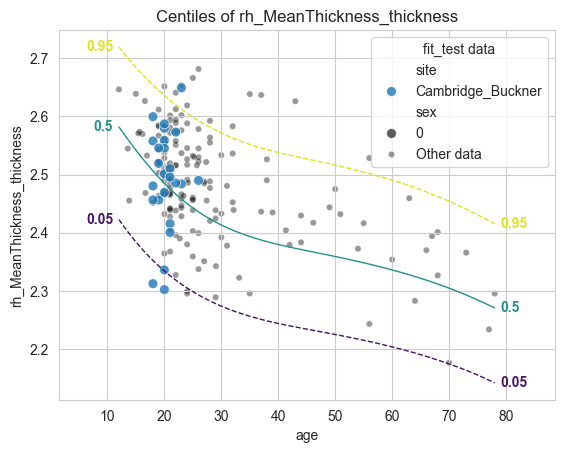

/opt/anaconda3/envs/forward_backward/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)


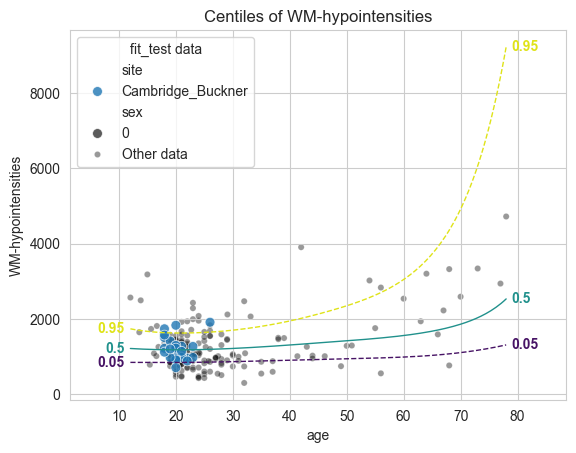

In [9]:
plot_centiles(
    normative_model,
    test,
    [0.05, 0.5, 0.95],
    "age",
    {"sex": ["0"], "site": ["Cambridge_Buckner"]},
    show_data=True,
    show_other_data=True,
)

In [10]:
model = NormativeModel.load(os.path.join(normative_model.save_dir))

Process: 28868 - Computing centiles for 2 response variables.
Process: 28868 - Computing centiles for rh_MeanThickness_thickness.
Process: 28868 - Computing centiles for WM-hypointensities.


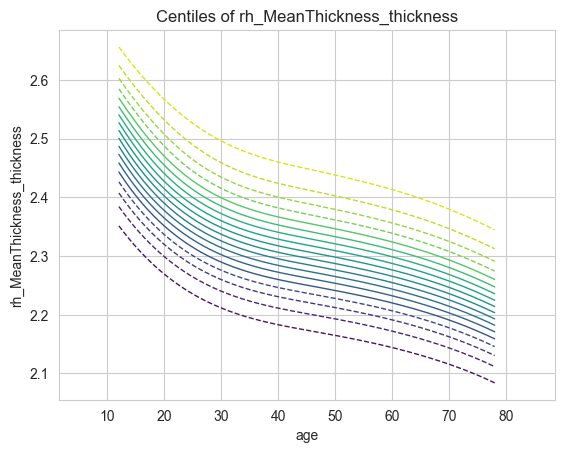

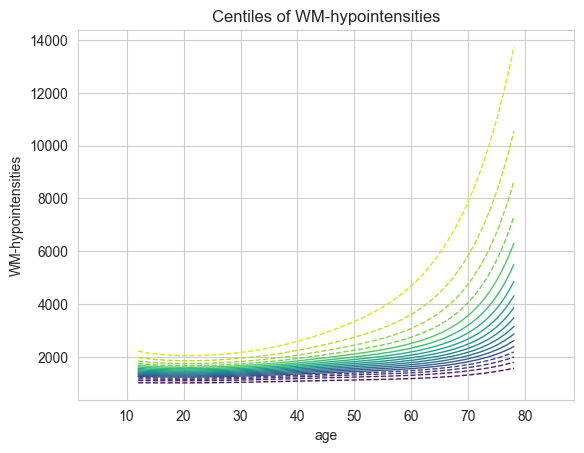

In [13]:
from pcntoolkit.util.plotter import plot_centiles
import numpy as np

plot_centiles(model, data=test, centiles=np.linspace(0, 1, 20), show_centile_labels=False)
